In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,accuracy_score
import matplotlib.pyplot as plt

In [3]:
transform = transforms.ToTensor()

In [4]:
train_data = datasets.MNIST(root="Data/",train=True,download=True,transform=transform)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
test_data = datasets.MNIST(root="Data/",train=False,download=True,transform=transform)

In [6]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)        
        self.fc2 = nn.Linear(120,84)  
        self.fc3 = nn.Linear(84,10)
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,16*5*5)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)
    

In [8]:
torch.manual_seed(42)
model = CNN()
model

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [9]:
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [11]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:  0  batch:  600 [  6000/60000]  loss: 0.04055629  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.08253472  accuracy:  85.800%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.36422709  accuracy:  88.689%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01856373  accuracy:  90.537%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00837751  accuracy:  91.680%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00242349  accuracy:  92.517%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.59992111  accuracy:  93.171%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02201787  accuracy:  93.633%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.00710493  accuracy:  94.054%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.05803911  accuracy:  94.370%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01296684  accuracy:  97.767%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.04782691  accuracy:  97.925%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00135268  accuracy:  97.922%
epoch:  1  b

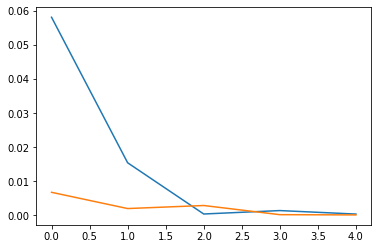

In [17]:
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "test loss")

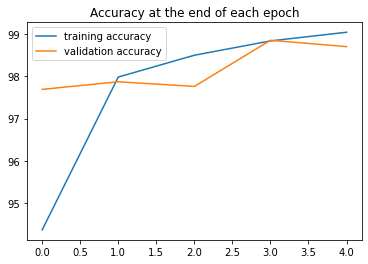

In [18]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [25]:
with torch.no_grad():
  accuracy = []
  for b,(features,labels) in enumerate(test_loader):
    logits = model(features)
    y_pred = logits.argmax(dim=1)
    acc = accuracy_score(y_pred,labels)
    accuracy.append(acc)


In [29]:
acc = sum(accuracy)/len(accuracy)
print("Accuracy is {:.2f}%".format(acc*100))

Accuracy is 98.70%
